In [1]:
from datasets import load_dataset
from IPython.display import Audio
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")

In [2]:
import soundfile
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [3]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import random
%matplotlib inline

def audio_to_spec(audio, n_fft=1024, hop_length=512):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    mag = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(mag)
    phase=np.angle(stft)
    return mag,phase


def spectrogram_to_audio(magl, phase, sr, n_fft=1024, hop_length=512):
    mag=librosa.db_to_amplitude(magl)
    stft = mag*np.exp(1j * phase) 
    audio = librosa.istft(stft, hop_length=hop_length)
    return audio

In [4]:
#get the waveform of audio
def wplot(arr,title="Waveform",xlab='Time (seconds)',ylab='Amplitude'):
    librosa.display.waveshow(arr, sr=16000)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()


def equal_audio(wav):
    wav=wav[:90000]
    zero_padding=tf.zeros([90000]-tf.shape(wav),dtype=tf.float64)
    wav=tf.concat([zero_padding,wav],0)
    spec=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spec=tf.abs(spec)
    spec=tf.expand_dims(spec,axis=2)
    return spec

#spectogram plot of audio
def spec_plot(spec,title="Spectogram",sr=16000):
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

#check the data array is it consistent or not
def check_data(arr,k=1600):
    cnt=0
    for el in arr:
        if len(el)!=k:
            cnt+=1
        
    return cnt

In [5]:
data=ds['train'].select(range(5000))

In [6]:
clean=[]
noisy=[]

for el in data:
    clean.append(np.array(el['clean']['array']))
    noisy.append(np.array(el['noisy']['array']))

In [7]:
def get_audio(arr):
    l=len(arr)
    idx=random.randint(0,l)
    print(f"duration of audio {len(clean[idx])/16000}")
    wplot(arr[idx],f"Waveform {idx}")

duration of audio 2.53


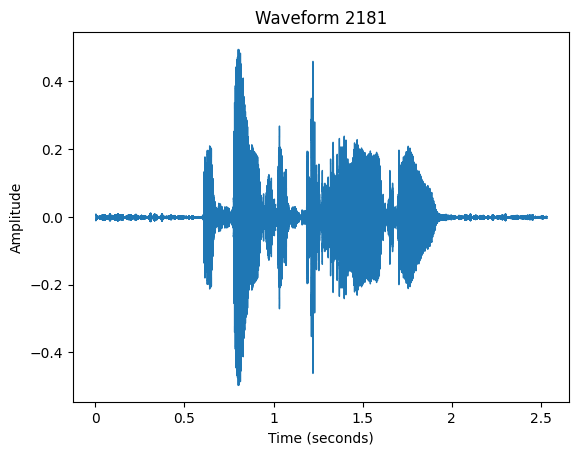

In [8]:
get_audio(clean)

In [9]:
def resize_audio(arr,r=16000):
    l=len(arr)
    i=0
    cnt=0
    br=[]
    brr=[]
    
    while i<l:
        br.append(arr[i])
        i+=1
        cnt+=1
        if cnt==r:
            brr.append(br)
            br=[]
            cnt=0

    if len(br)!=0:
        br.extend([0]*(r-len(br)))
        brr.append(br)
    
    return brr

In [10]:
cleanr=[]
noisyr=[]

In [11]:
for e in clean:
    cleanr.extend(resize_audio(e))

In [12]:
for e in noisy:
    noisyr.extend(resize_audio(e))

In [13]:
len(cleanr),len(noisyr)

(17084, 17084)

In [14]:
l=len(cleanr)
idx=random.randint(0,l)

In [15]:
cleanr=np.array(cleanr)
noisyr=np.array(noisyr)

In [16]:
st=set()

for e in noisyr:
    st.add(len(e))

st

{16000}

In [17]:
def get_spectrogram_features(cleanr,noisyr,sample_rate = 16000, duration_s = 1):
    '''
    Function to generate features for audio de-noising [spectogram] 
    - Sets to a fixed length.
    - Generates spectrogram.
    - Adds noise and generates corresponding spectrogram.
    - Outputs clean and noisy spectrogram features.
    '''
    X_clean = []
    X_noisy = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)

    for data in cleanr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        X_clean.append(S)

    
    
    for data in noisyr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        X_noisy.append(S)
    
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)

    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)
       
    return X_clean, X_noisy

In [18]:
sample_rate = 16000
X_clean, X_noisy = get_spectrogram_features(cleanr, noisyr,sample_rate = sample_rate)
spec_shape = (X_clean.shape[1], X_clean.shape[2])

In [19]:
np.save('clean_train.npy',X_clean)
np.save('noisy_train.npy',X_noisy)

In [20]:
def specs(arr):
    S = np.abs(librosa.stft(arr, n_fft = 1024))
    data_inv = librosa.griffinlim(S)
    
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
    plt.show()

In [21]:
X_clean[0].shape

(1024, 32, 1)

In [22]:
def sample_spec():
    l=X_clean.shape[0]
    idx=random.randint(0,l)
    print(f"the index plotting {idx}")
    arr=np.squeeze(X_clean[idx],axis= -1)
    brr=np.squeeze(X_noisy[idx],axis= -1)
    print("clean stft")
    spec_plot(arr)
    print(" noisy stft")
    spec_plot(brr)

the index plotting 677
clean stft


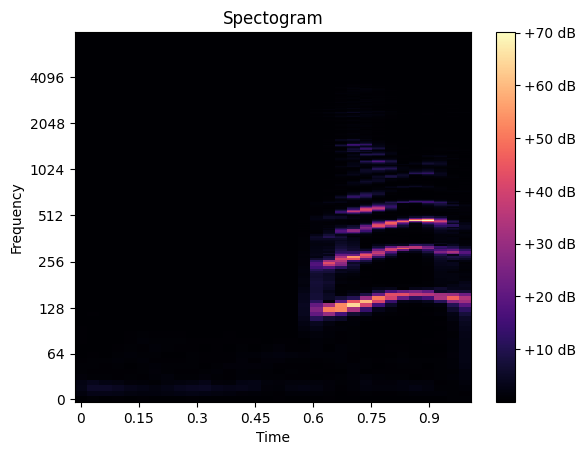

 noisy stft


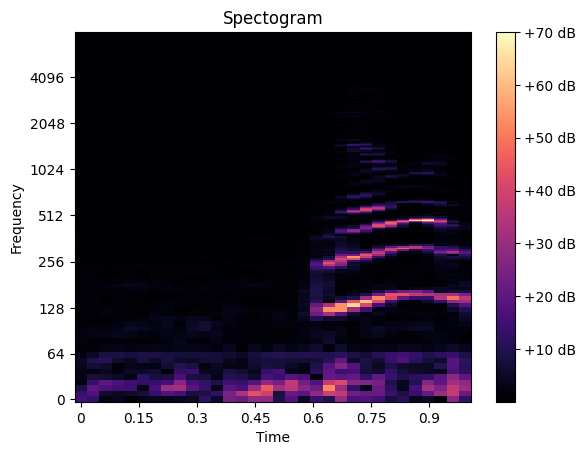

In [23]:
sample_spec()